In [1]:
from src.test_non_local_switching_non_stationary_model import load_data

is_ripple, spikes, position, speed, env, time = load_data(work_computer=False)


(22709.082875307, 22789.082875307)

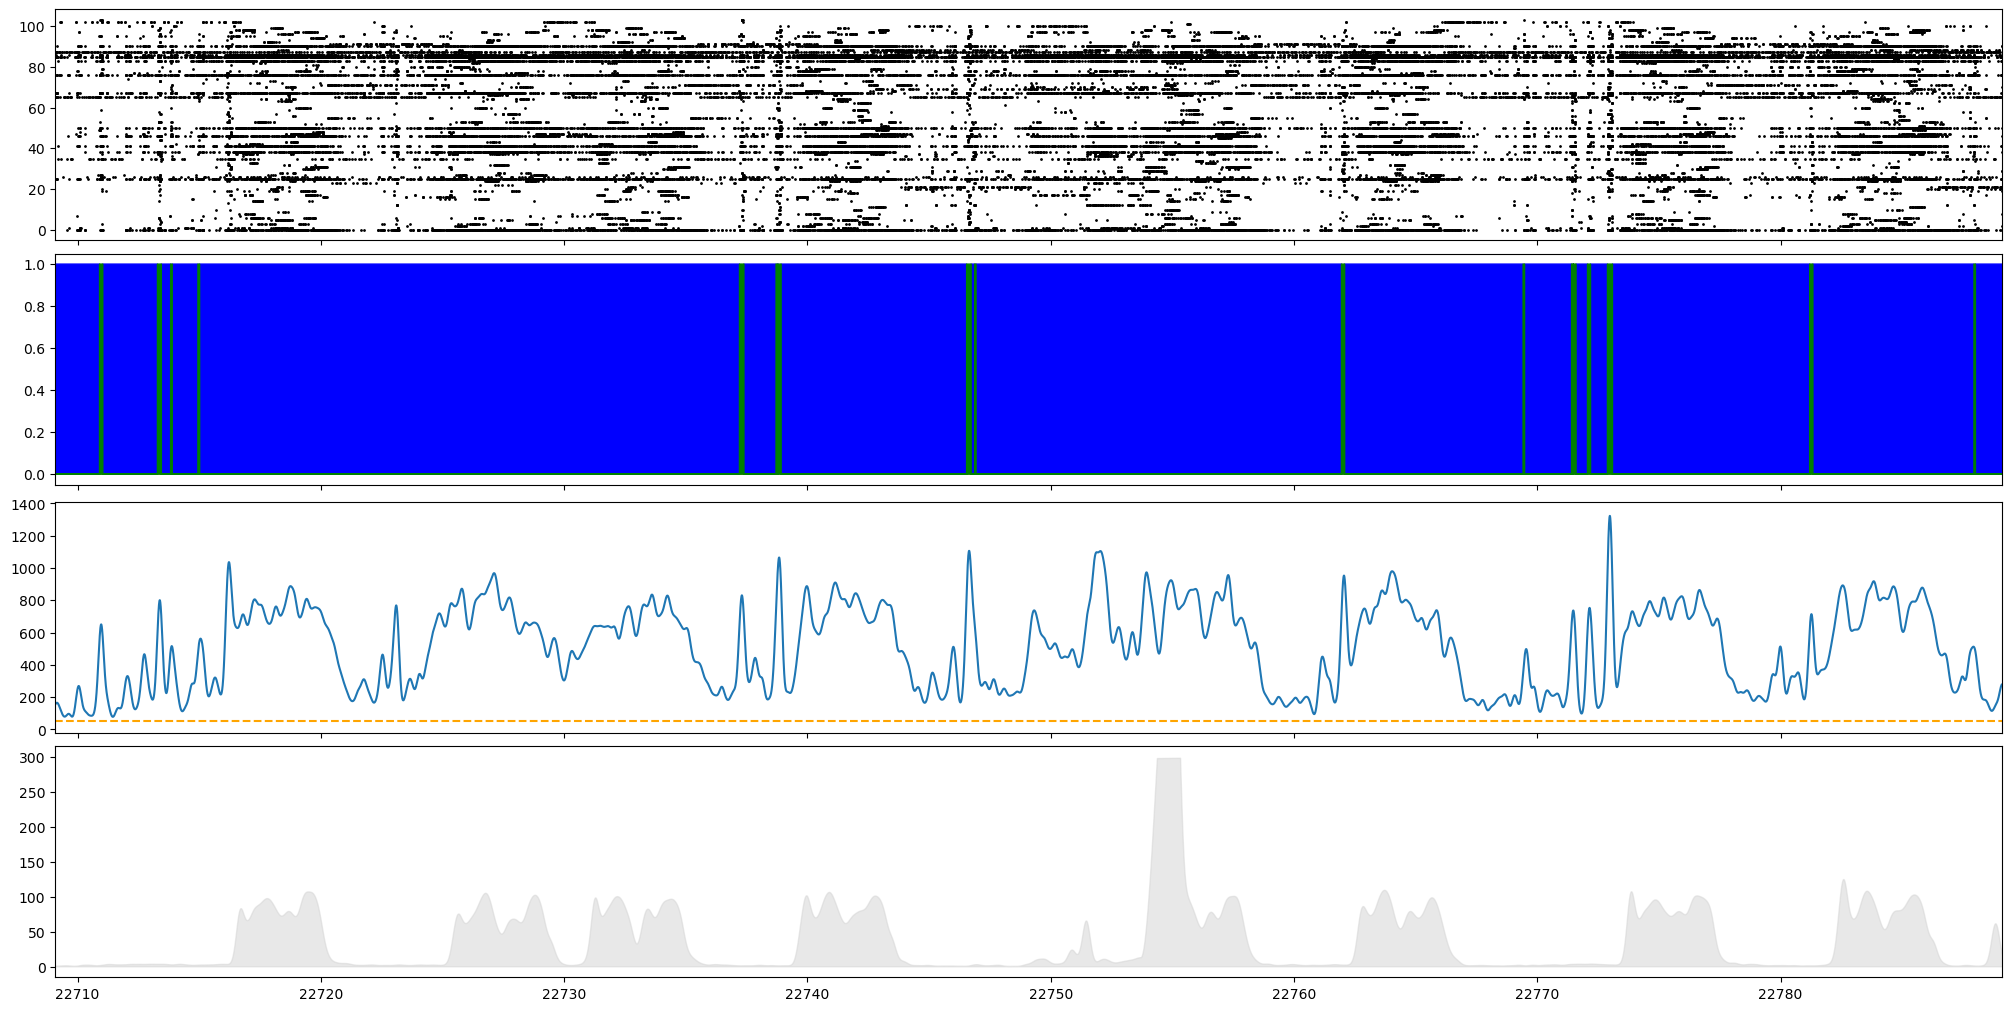

In [2]:
from src.test_non_local_switching_non_stationary_model import (
    estimate_no_spike_times,
    gaussian_smooth,
)
import numpy as np

import matplotlib.pyplot as plt

sampling_frequency = 500
no_spike_smoothing_sigma = 0.100
no_spike_rate_threshold = 50
no_spike_speed_threshold = 4.0

is_no_spike_time = estimate_no_spike_times(
    spikes,
    speed=speed,
    sampling_frequency=sampling_frequency,
    sigma=no_spike_smoothing_sigma,
    rate_threshold=no_spike_rate_threshold,
    speed_threshold=no_spike_speed_threshold,
)
spike_rate = (
    gaussian_smooth(
        spikes.sum(axis=1).astype(float),
        sigma=no_spike_smoothing_sigma,
        sampling_frequency=sampling_frequency,
    )
    * sampling_frequency
)
is_local_time = np.logical_and(~is_ripple, ~is_no_spike_time)

state_names = ["local", "no_spike", "non_local"]
n_states = len(state_names)

fig, axes = plt.subplots(4, 1, sharex=True, constrained_layout=True, figsize=(20, 10))

is_non_local_time = is_ripple

spike_time_ind, neuron_ind = np.nonzero(spikes)

axes[0].scatter(time[spike_time_ind], neuron_ind, s=1, c="k")
axes[1].fill_between(time, is_local_time, color="blue")
axes[1].fill_between(time, is_no_spike_time, color="orange")
axes[1].fill_between(time, is_non_local_time, color="green")
axes[2].plot(time, spike_rate)
axes[2].axhline(no_spike_rate_threshold, color="orange", linestyle="--")
axes[3].fill_between(time, speed, color="lightgrey", alpha=0.5)

plt.xlim((time[160_000], time[200_000]))


In [3]:
speed_knots = [1.0, 4.0, 16.0, 32.0, 64.0]

Optimization terminated successfully.
         Current function value: 0.001222
         Iterations: 14
         Function evaluations: 14
         Gradient evaluations: 14
         Hessian evaluations: 14
         Current function value: 0.024142
         Iterations: 18
         Function evaluations: 70
         Gradient evaluations: 58
         Hessian evaluations: 19
Optimization terminated successfully.
         Current function value: 0.033011
         Iterations: 10
         Function evaluations: 10
         Gradient evaluations: 10
         Hessian evaluations: 10


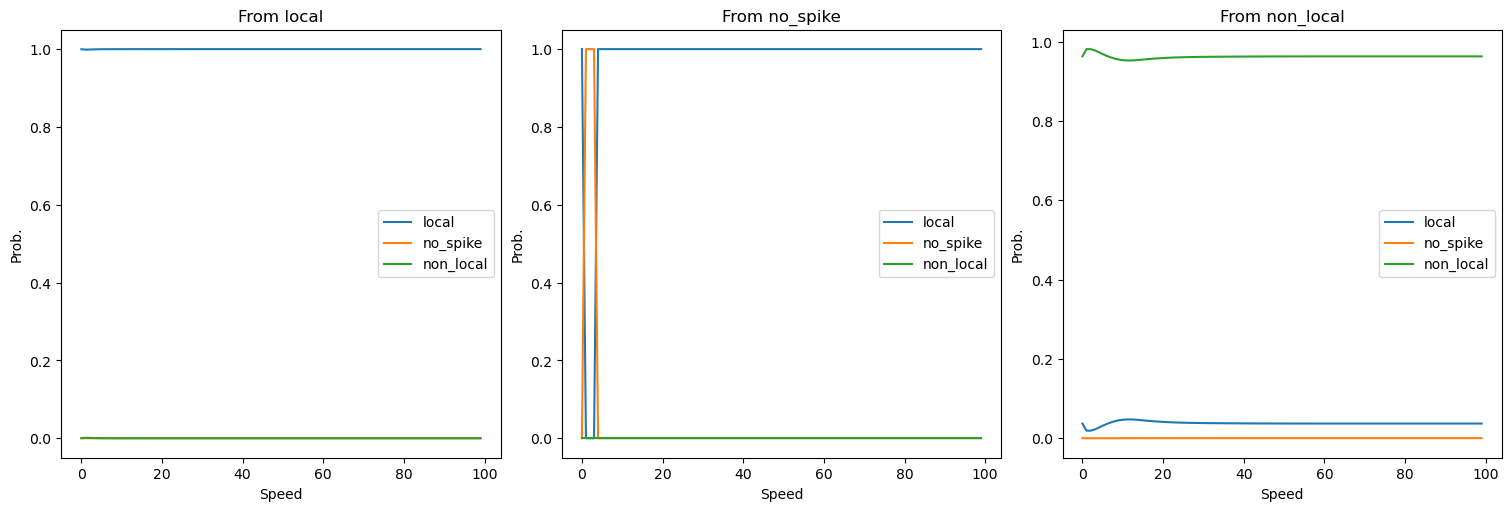

In [4]:
from src.test_non_local_switching_non_stationary_model import (
    lagmat,
    dmatrix,
    minimize,
    transition_neg_log_likelihood,
    transition_gradient,
    transition_hessian,
    centered_softmax_forward,
)
from patsy import build_design_matrices

speed_knots = None

from_states = {
    "local": lagmat(is_local_time, maxlag=1).astype(bool).squeeze(),
    "no_spike": lagmat(is_no_spike_time, maxlag=1).astype(bool).squeeze(),
    "non_local": lagmat(is_ripple, maxlag=1).astype(bool).squeeze(),
}

if speed_knots is None:
    speed_knots = [1.0, 4.0, 16.0, 32.0, 64.0]

n_time = spikes.shape[0]

formula = f"1 + bs(speed, knots={speed_knots})"
data = {"speed": lagmat(speed, maxlag=1)}
discrete_transition_design_matrix = dmatrix(formula, data)

n_time, n_coefficients = discrete_transition_design_matrix.shape

response = np.zeros((n_time, n_states))
response[is_local_time.astype(bool), 0] = 1.0
response[is_no_spike_time.astype(bool), 1] = 1.0
response[is_ripple.astype(bool), 2] = 1.0

starting_prob = np.zeros(
    (
        n_coefficients,
        n_states - 1,
    )
).ravel()

discrete_state_transitions = np.zeros((n_time, n_states, n_states))
discrete_transition_coefficients = np.zeros((n_coefficients, n_states, n_states - 1))

for from_state_ind, from_state in enumerate(state_names):
    is_from_state = from_states[from_state]
    res = minimize(
        transition_neg_log_likelihood,
        x0=starting_prob,
        jac=transition_gradient,
        hess=transition_hessian,
        args=(
            discrete_transition_design_matrix[is_from_state],
            response[is_from_state],
        ),
        method="Newton-CG",
        options={
            "disp": True,
            "maxiter": 100,
        },
    )
    discrete_transition_coefficients[:, from_state_ind, :] = res.x.reshape(
        (
            n_coefficients,
            n_states - 1,
        )
    )
    discrete_state_transitions[:, from_state_ind, :] = centered_softmax_forward(
        discrete_transition_design_matrix
        @ discrete_transition_coefficients[:, from_state_ind, :]
    )



predict_data = {"speed": np.arange(0, 100.0)}
predict_matrix = build_design_matrices(
    [discrete_transition_design_matrix.design_info], predict_data
)[0]


fig, axes = plt.subplots(1, 3, sharex=True, constrained_layout=True, figsize=(15, 5))

for from_state_ind, (ax, from_state) in enumerate(zip(axes.flat, state_names)):
    from_local_transition = centered_softmax_forward(
        predict_matrix @ discrete_transition_coefficients[:, from_state_ind]
    )

    ax.plot(predict_data["speed"], from_local_transition)
    ax.set_xlabel("Speed")
    ax.set_ylabel("Prob.")
    ax.legend(state_names)
    ax.set_title(f"From {from_state}")


         Current function value: 0.002119
         Iterations: 100
         Function evaluations: 101
         Gradient evaluations: 101
         Hessian evaluations: 100
         Current function value: 0.029452
         Iterations: 100
         Function evaluations: 102
         Gradient evaluations: 102
         Hessian evaluations: 100
Optimization terminated successfully.
         Current function value: 0.002250
         Iterations: 68
         Function evaluations: 68
         Gradient evaluations: 68
         Hessian evaluations: 68


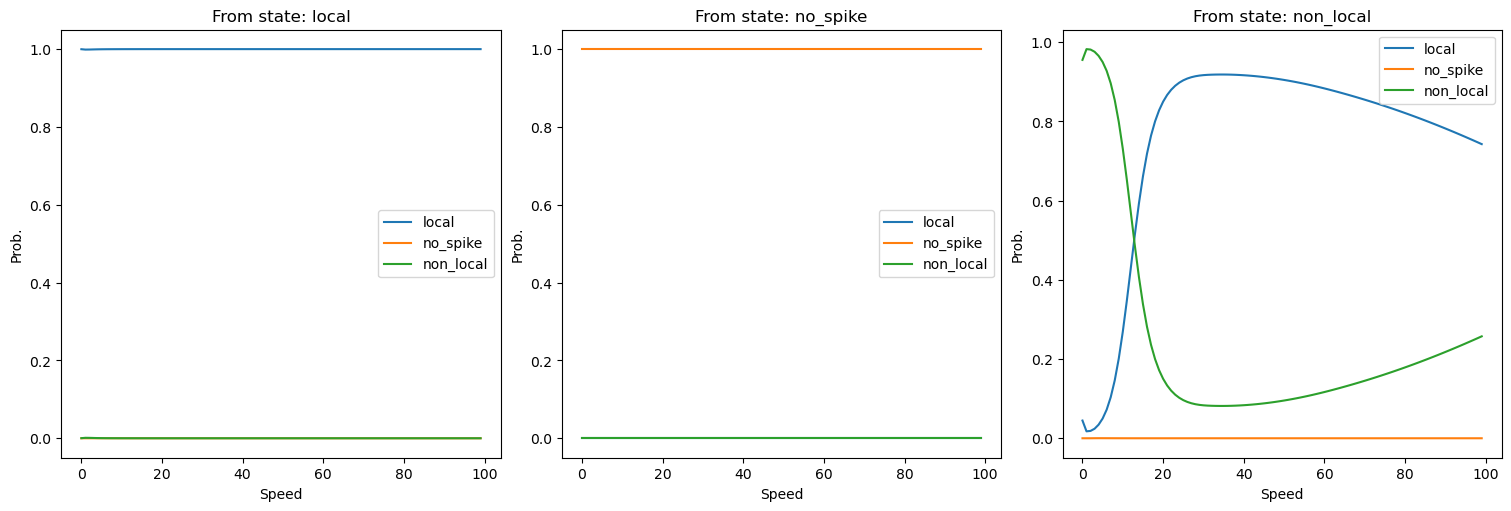

In [5]:
from src.test_non_local_switching_non_stationary_model import (
    lagmat,
    dmatrix,
    minimize,
    transition_neg_log_likelihood,
    transition_gradient,
    transition_hessian,
    centered_softmax_forward,
)
from patsy import build_design_matrices

fig, axes = plt.subplots(1, len(state_names), sharex=True, constrained_layout=True, figsize=(15, 5))
for ax, from_state in zip(axes.flat, state_names):

    formula = f"1 + {from_state} + bs(speed, knots={speed_knots})"
    data = {
        "speed": lagmat(speed, maxlag=1),
        "local": lagmat(is_local_time, maxlag=1).astype(bool).squeeze(),
        "no_spike": lagmat(is_no_spike_time, maxlag=1).astype(bool).squeeze(),
        "non_local": lagmat(is_ripple, maxlag=1).astype(bool).squeeze(),
    }
    discrete_transition_design_matrix = dmatrix(formula, data)

    n_time, n_coefficients = discrete_transition_design_matrix.shape

    response = np.zeros((n_time, n_states))
    response[is_local_time.astype(bool), 0] = 1.0
    response[is_no_spike_time.astype(bool), 1] = 1.0
    response[is_ripple.astype(bool), 2] = 1.0

    starting_prob = np.zeros(
        (
            n_coefficients,
            n_states - 1,
        )
    ).ravel()

    res = minimize(
        transition_neg_log_likelihood,
        x0=starting_prob,
        jac=transition_gradient,
        hess=transition_hessian,
        args=(
            discrete_transition_design_matrix,
            response,
        ),
        method="Newton-CG",
        options={
            "disp": True,
            "maxiter": 100,
        },
    )

    predict_data = {
        "speed": np.arange(0, 100.0),
        from_state: np.ones((100,)),
    }
    predict_matrix = build_design_matrices(
        [discrete_transition_design_matrix.design_info], predict_data
    )[0]

    coef = res.x.reshape(
            (
                n_coefficients,
                n_states - 1,
            )
    )

    ax.plot(predict_data["speed"], centered_softmax_forward(predict_matrix @ coef))
    ax.set_xlabel("Speed")
    ax.set_ylabel("Prob.")
    ax.legend(state_names)
    ax.set_title(f"From state: {from_state}")